In [1]:
# Import 
import os
import time
import json
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet#, SheetGeometry as geom
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry as geom
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
import ipyvolume as ipv
ipv.clear()

In [2]:
def open_sheet(dirname, t, data_names=['vert', 'edge', 'face', 'cell']):
    """Open hdf5 file

    Open HDF5 file correspond to t time from dirname directory.

    Parameters
    ----------
    directory : str
        complete directory path
    t : int
        time step
    """
    file_name = 'invagination_{:04d}.hf5'.format(t)
    dsets = hdf5.load_datasets(os.path.join(dirname, file_name),
                               data_names=data_names)

    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('ellipse', dsets, specs)
    return sheet


def depth_calculation(sheet, min_, max_):
    # Caculation of the radius
    sheet_fold = sheet.extract_bounding_box(z_boundary=(min_,max_))
    r = np.sqrt(np.abs(sheet_fold.face_df.x).mean()**2 + np.abs(sheet_fold.face_df.y).mean()**2)
    return r


In [3]:
def define_last_apopto_depth(directory):
    
    sheet = open_sheet(directory,0)
    depth_0 = len(sheet.face_df.apoptosis)

    depths = []
    for t in range(0, 200):
        try:
            sheet = open_sheet(directory,t)
            d = len(sheet.face_df.apoptosis)
            depths.append(d)
        except Exception:
            pass

    time = depths.index(min(depths))
    depth_max = min(depths)
    print(time, depth_max)
    return time, depth_max

In [4]:
def define_time_max_depth(directory):
    
    sheet = open_sheet(directory,0)
    depth_0 = depth_calculation(sheet, -7, 7)

    depths = []
    for t in range(0, 200):
        try:
            sheet = open_sheet(directory,t)
            depths.append((depth_calculation(sheet, -7, 7))/depth_0)
        except Exception:
            pass

    time = depths.index(min(depths))
    depth_max = min(depths)
    print(time, depth_max)
    return time, depth_max

def define_time_max_depth_v2(directory):
    
    sheet = open_sheet(directory,0)
    sheet = sheet.extract_bounding_box(y_boundary=(0,150))
    depth_0 = depth_calculation(sheet, -7, 7)

    depths_up = []
    for t in range(0, 200):
        try:
            sheet = open_sheet(directory,t)
            sheet = sheet.extract_bounding_box(y_boundary=(0,150))
            depths_up.append((depth_calculation(sheet, -7, 7)))
        except Exception:
            pass

    sheet = open_sheet(directory,0)
    sheet = sheet.extract_bounding_box(y_boundary=(-150,0))
    depth_0 = depth_calculation(sheet, -7, 7)

    depths_down = []
    for t in range(0, 200):
        try:
            sheet = open_sheet(directory,t)
            sheet = sheet.extract_bounding_box(y_boundary=(-150,0))
            depths_down.append((depth_calculation(sheet, -7, 7)))
        except Exception:
            pass
    
    depths=[]
    for i in range (len(depths_up)):
        depths.append(np.abs(depths_up[i]-depths_down[i]))
        
    depths= depths[15:]
    time = depths.index(min(depths))+15
    depth_max = min(depths)
    print(time, depth_max)
    return time, depth_max

In [5]:
def panel_sagittal_view(directory, df, ax=None):
    print(directory)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    """t, d = define_time_max_depth(directory)
    df.loc[str(directory).split('/')[-1], 'time'] = t
    df.loc[str(directory).split('/')[-1], 'depth'] = d"""
    #t, d = define_last_apopto_depth(directory)
    t, d = define_time_max_depth(directory)
    sheet = open_sheet(directory, t)
    
    """# Calcul du rapport de force
    r = force_ratio(sheet)
    df.loc[str(directory).split('/')[-1], 'Fab/Fc'] = r
    print(directory)
    print(df.loc[str(directory).split('/')[-1]])"""

    # sagital view
    #fig, ax = quick_edge_draw(sheet, ['z', 'x'],
    #                          alpha=0.7, ax=ax)

    def draw_specs(sheet):
        specs = {
            'face': {
            'visible': True,
            #'color': np.sqrt((sheet.face_df.x)**2 + (sheet.face_df.y)**2),
            'color':sheet.face_df.y, 
            'colormap': 'viridis',
            'alpha': 0.8,
            #'color_range':(20,45),
            },
            'edge': {
                'visible': True,
                'color':'black',
                #'color': np.sqrt((sheet.edge_df.sx)**2 + (sheet.edge_df.sy)**2),
                #'colormap': 'viridis',
            },
            'vert':{
                'visible':False,
                's':100,
                'alpha': 0.3,
                'zorder': 2,
                'color': sheet.vert_df.radial_tension

            }

        }
        return specs
    
    sheet = sheet.extract_bounding_box(z_boundary=[-60,60], y_boundary=(0,100))
    #sheet = sheet.extract_bounding_box(y_boundary=(0,100))
    fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                         ax= ax, **draw_specs(sheet))
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    #ax.text(1, 2, round(r, 3), horizontalalignment='center',
    #        verticalalignment='center')

In [ ]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold')
dirname = SIM_DIR
list_dir = os.listdir(dirname)

import matplotlib
import matplotlib.gridspec as gridspec
matplotlib.rc('axes', edgecolor='white')

result_dataframe = pd.DataFrame(index = list_dir, columns = ('time', 'depth', 'Fab/Fc'))




fig = plt.figure(figsize=(25, 20))
grid = gridspec.GridSpec(5, 6, wspace=0.0, hspace=0.0)


axes_2_1 = fig.add_subplot(grid[0, 0])
axes_2_2 = fig.add_subplot(grid[0, 1])
axes_2_3 = fig.add_subplot(grid[0, 2])
axes_2_4 = fig.add_subplot(grid[0, 3])
axes_2_5 = fig.add_subplot(grid[0, 4])
axes_2_6 = fig.add_subplot(grid[0, 5])

axes_3_1 = fig.add_subplot(grid[1, 0])
axes_3_2 = fig.add_subplot(grid[1, 1])
axes_3_3 = fig.add_subplot(grid[1, 2])
axes_3_4 = fig.add_subplot(grid[1, 3])
axes_3_5 = fig.add_subplot(grid[1, 4])
axes_3_6 = fig.add_subplot(grid[1, 5])

axes_4_1 = fig.add_subplot(grid[2, 0])
axes_4_2 = fig.add_subplot(grid[2, 1])
axes_4_3 = fig.add_subplot(grid[2, 2])
axes_4_4 = fig.add_subplot(grid[2, 3])
axes_4_5 = fig.add_subplot(grid[2, 4])
axes_4_6 = fig.add_subplot(grid[2, 5])

axes_5_1 = fig.add_subplot(grid[3, 0])
axes_5_2 = fig.add_subplot(grid[3, 1])
axes_5_3 = fig.add_subplot(grid[3, 2])
axes_5_4 = fig.add_subplot(grid[3, 3])
axes_5_5 = fig.add_subplot(grid[3, 4])
axes_5_6 = fig.add_subplot(grid[3, 5])

axes_6_1 = fig.add_subplot(grid[4, 0])
axes_6_2 = fig.add_subplot(grid[4, 1])
axes_6_3 = fig.add_subplot(grid[4, 2])
axes_6_4 = fig.add_subplot(grid[4, 3])
axes_6_5 = fig.add_subplot(grid[4, 4])
axes_6_6 = fig.add_subplot(grid[4, 5])


panel_sagittal_view(dirname/'1.32_constriction_0_radialtension0/', result_dataframe, axes_2_1)
panel_sagittal_view(dirname/'1.32_constriction_10_radialtension0/', result_dataframe, axes_2_2)
panel_sagittal_view(dirname/'1.32_constriction_20_radialtension0/', result_dataframe, axes_2_3)
panel_sagittal_view(dirname/'1.32_constriction_30_radialtension0/', result_dataframe, axes_2_4)
panel_sagittal_view(dirname/'1.32_constriction_40_radialtension0/', result_dataframe,axes_2_5)
panel_sagittal_view(dirname/'1.32_constriction_50_radialtension0/', result_dataframe,axes_2_6)

panel_sagittal_view(dirname/'1.16_constriction_0_radialtension0/', result_dataframe, axes_3_1)
panel_sagittal_view(dirname/'1.16_constriction_10_radialtension0/', result_dataframe, axes_3_2)
panel_sagittal_view(dirname/'1.16_constriction_20_radialtension0/', result_dataframe, axes_3_3)
panel_sagittal_view(dirname/'1.16_constriction_30_radialtension0/', result_dataframe, axes_3_4)
panel_sagittal_view(dirname/'1.16_constriction_40_radialtension0/', result_dataframe, axes_3_5)
panel_sagittal_view(dirname/'1.16_constriction_50_radialtension0/', result_dataframe, axes_3_6)

panel_sagittal_view(dirname/'1.08_constriction_0_radialtension0/', result_dataframe, axes_4_1)
panel_sagittal_view(dirname/'1.08_constriction_10_radialtension0/', result_dataframe, axes_4_2)
panel_sagittal_view(dirname/'1.08_constriction_20_radialtension0/', result_dataframe, axes_4_3)
panel_sagittal_view(dirname/'1.08_constriction_30_radialtension0/', result_dataframe, axes_4_4)
panel_sagittal_view(dirname/'1.08_constriction_40_radialtension0/', result_dataframe, axes_4_5)
panel_sagittal_view(dirname/'1.08_constriction_50_radialtension0/', result_dataframe, axes_4_6)

panel_sagittal_view(dirname/'1.04_constriction_0_radialtension0/', result_dataframe, axes_5_1)
panel_sagittal_view(dirname/'1.04_constriction_10_radialtension0/', result_dataframe, axes_5_2)
panel_sagittal_view(dirname/'1.04_constriction_20_radialtension0/', result_dataframe, axes_5_3)
panel_sagittal_view(dirname/'1.04_constriction_30_radialtension0/', result_dataframe, axes_5_4)
panel_sagittal_view(dirname/'1.04_constriction_40_radialtension0/', result_dataframe, axes_5_5)
panel_sagittal_view(dirname/'1.04_constriction_50_radialtension0/', result_dataframe, axes_5_6)

panel_sagittal_view(dirname/'1.02_constriction_0_radialtension0/', result_dataframe, axes_6_1)
panel_sagittal_view(dirname/'1.02_constriction_10_radialtension0/', result_dataframe, axes_6_2)
panel_sagittal_view(dirname/'1.02_constriction_20_radialtension0/', result_dataframe, axes_6_3)
panel_sagittal_view(dirname/'1.02_constriction_30_radialtension0/', result_dataframe, axes_6_4)
panel_sagittal_view(dirname/'1.02_constriction_40_radialtension0/', result_dataframe, axes_6_5)
panel_sagittal_view(dirname/'1.02_constriction_50_radialtension0/', result_dataframe, axes_6_6)


axes_2_1.set_ylabel('32', size=20, family='Arial')
axes_3_1.set_ylabel('16', size=20, family='Arial')
axes_4_1.set_ylabel('8', size=20, family='Arial')
axes_5_1.set_ylabel('4', size=20, family='Arial')
axes_6_1.set_ylabel('2', size=20, family='Arial')

axes_6_1.set_xlabel('0', size=20, family='Arial')
axes_6_2.set_xlabel('10', size=20, family='Arial')
axes_6_3.set_xlabel('20', size=20, family='Arial')
axes_6_4.set_xlabel('30', size=20, family='Arial')
axes_6_5.set_xlabel('40', size=20, family='Arial')
axes_6_6.set_xlabel('50', size=20, family='Arial')


#plt.savefig('../paper/contract_force.svg', dpi = 300)
#result_dataframe.to_csv('result_principal_result.csv')
#plt.savefig('../maximal_depth.svg', dpi = 300)
#plt.savefig('../maximal_depth.eps', dpi = 300)
plt.savefig('../maximal_depth.png', dpi = 300)
result_dataframe.to_csv('../maximal_depth.csv')

/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_0_radialtension0
62 0.8038141401041426
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_10_radialtension0
62 0.7665392647097613
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_20_radialtension0
31 0.701027584546106
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_30_radialtension0
40 0.6330757598526227
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_40_radialtension0
35 0.43500486669586996
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.32_constriction_50_radialtension0
40 0.324582346963356
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.16_constriction_0_radialtension0
141 0.8825162768687413
/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold/1.16_constriction_10_radialt

147 0.7973964631790524
140 0.7858940934223294
114 0.6733392527094741
100 0.6275584158490006
70 0.49127315698288615
62 0.42970446379002597
1.02
{'0': 0.7973964631790524, '10': 0.7858940934223294, '20': 0.6733392527094741, '30': 0.6275584158490006, '40': 0.49127315698288615, '50': 0.42970446379002597}
104 0.8485172170429557
77 0.8226565946101602
88 0.708936108240636
83 0.6483383943251407
61 0.42168855837066316
55 0.4326653419895197
1.04
{'0': 0.8485172170429557, '10': 0.8226565946101602, '20': 0.708936108240636, '30': 0.6483383943251407, '40': 0.42168855837066316, '50': 0.4326653419895197}
81 0.8674014710616836
63 0.8397019191509774
80 0.7374591716293463
62 0.6610710237023126
42 0.5015776346221406
46 0.3861356946373234
1.08
{'0': 0.8674014710616836, '10': 0.8397019191509774, '20': 0.7374591716293463, '30': 0.6610710237023126, '40': 0.5015776346221406, '50': 0.3861356946373234}
141 0.8825162768687413
43 0.842536297512224
62 0.7458227171739928
45 0.6710775639345945
41 0.5175921214619564
46

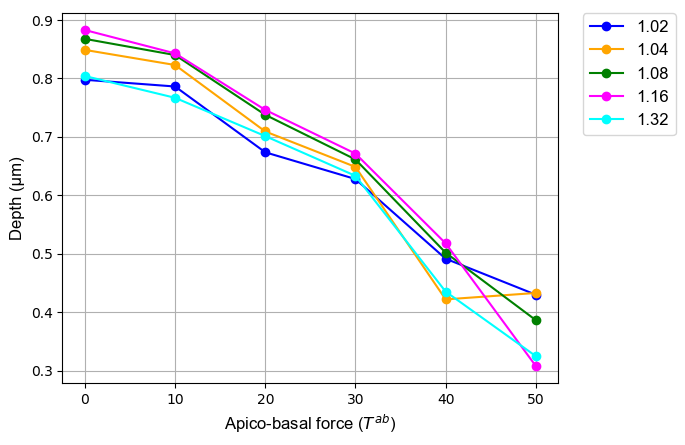

In [113]:

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
contractility = ['1.02', '1.04','1.08', '1.16', '1.32']
force = ['0', '10', '20', '30', '40', '50']
color = ['blue', 'orange', 'green', 'magenta', 'cyan']
list_dir=os.listdir(dirname)

fig, ax = plt.subplots()
i=0
l = []
for c in contractility : 
    stores = [f for f in list_dir if not(f.find(c))] 
    list_t = {}
    for fab in force : 
        file_directory = [f for f in stores if (f.find(str('_'+fab+'_')))>0] [0]
        
        t,d =  define_time_max_depth(os.path.join(dirname, file_directory))
        list_t[fab] = d
        
        #list_t[fab] = result_dataframe.loc[file_directory,'depth']
    
    print(c)
    print(list_t)
    l.append(list_t)
    ax.plot ([int (u)for u in list_t.keys()], [float (u)for u in list_t.values()], 
             '.-',markersize=12, label = round(float(c), 2), color=color[i])
    i+=1


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 12, 'family':'Arial'})
ax.set_xlabel('Apico-basal force ($T^{ab}$)', size=12, family='Arial')
ax.set_ylabel('Depth (µm)', size=12, family='Arial')
ax.grid(True)
fig.savefig('../depth_contractility.eps', dpi = 300)
fig.savefig('../depth_contractility.png', dpi = 300)
plt.show()

In [115]:
l

[{'0': 0.7973964631790524,
  '10': 0.7858940934223294,
  '20': 0.6733392527094741,
  '30': 0.6275584158490006,
  '40': 0.49127315698288615,
  '50': 0.42970446379002597},
 {'0': 0.8485172170429557,
  '10': 0.8226565946101602,
  '20': 0.708936108240636,
  '30': 0.6483383943251407,
  '40': 0.42168855837066316,
  '50': 0.4326653419895197},
 {'0': 0.8674014710616836,
  '10': 0.8397019191509774,
  '20': 0.7374591716293463,
  '30': 0.6610710237023126,
  '40': 0.5015776346221406,
  '50': 0.3861356946373234},
 {'0': 0.8825162768687413,
  '10': 0.842536297512224,
  '20': 0.7458227171739928,
  '30': 0.6710775639345945,
  '40': 0.5175921214619564,
  '50': 0.30768200591361894},
 {'0': 0.8038141401041426,
  '10': 0.7665392647097613,
  '20': 0.701027584546106,
  '30': 0.6330757598526227,
  '40': 0.43500486669586996,
  '50': 0.324582346963356}]

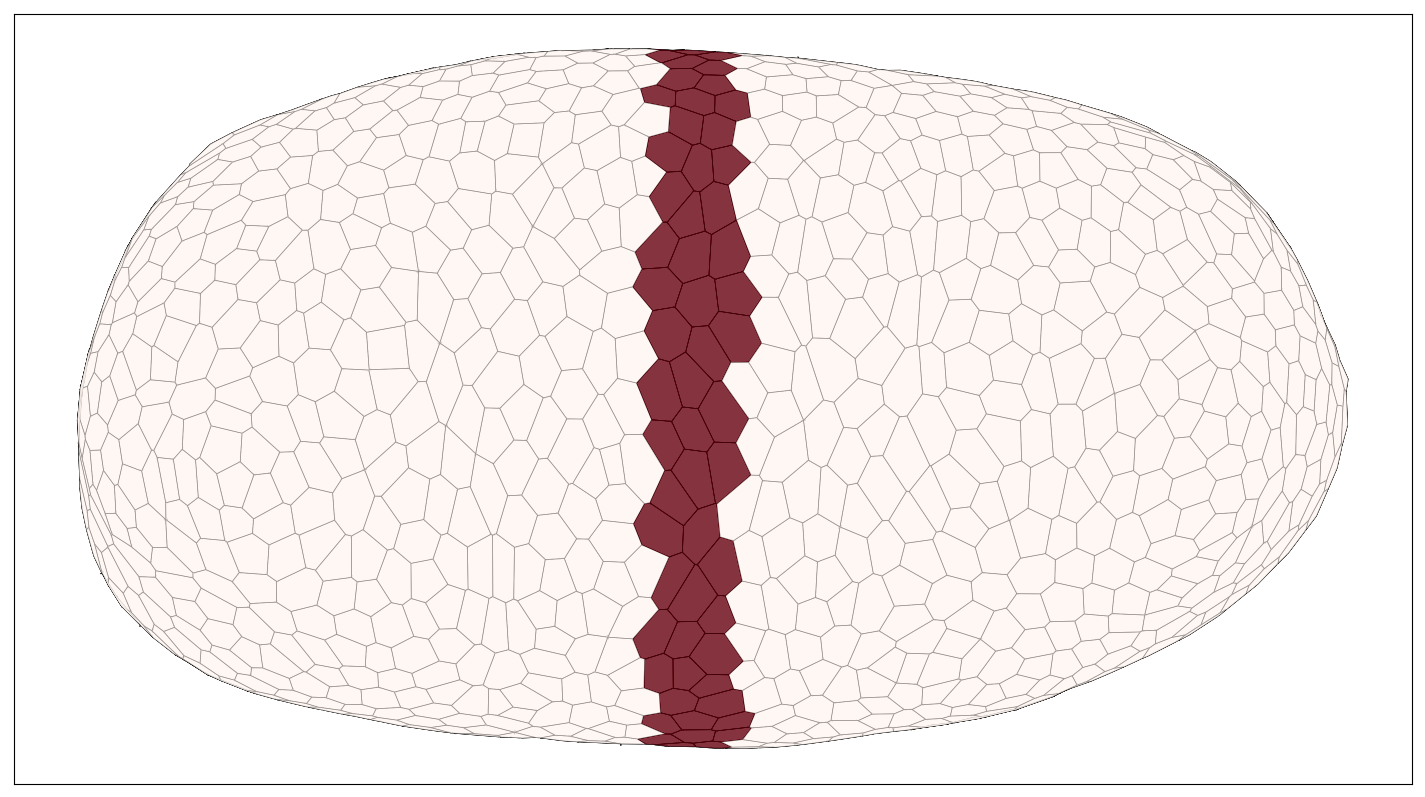

In [61]:

def open_sheet(dirname, t, data_names=['vert', 'edge', 'face', 'cell']):
    """Open hdf5 file

    Open HDF5 file correspond to t time from dirname directory.

    Parameters
    ----------
    directory : str
        complete directory path
    t : int
        time step
    """
    file_name = 'invagination_{:04d}.hf5'.format(t)
    dsets = hdf5.load_datasets(os.path.join(dirname, file_name),
                               data_names=data_names)

    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('ellipse', dsets, specs)
    return sheet

SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold')
dirname = SIM_DIR
sheet = open_sheet(dirname/'1.32_constriction_0_radialtension0/', 0)
fig, ax = plt.subplots()

def draw_specs(sheet):
    specs = {
        'face': {
        'visible': True,
        #'color': np.sqrt((sheet.face_df.x)**2 + (sheet.face_df.y)**2),
        'color':sheet.face_df.fold, 
        'colormap': 'Reds',
        'alpha':0.8
        #'color_range':(20,45),
        },
        'edge': {
            'visible': True,
            'color':'black',
            #'color': np.sqrt((sheet.edge_df.sx)**2 + (sheet.edge_df.sy)**2),
            #'colormap': 'viridis',
        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,
            'color': sheet.vert_df.radial_tension

        }

    }
    return specs

sheet= sheet.extract_bounding_box(y_boundary=(0, 100))
fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                     ax= ax, **draw_specs(sheet))
ax.grid(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.set_size_inches(20, 10, forward=True)
fig.savefig('../initial_onefold.png', dpi=300)
fig.savefig('../initial_onefold.eps', dpi=300)
fig.savefig('../initial_onefold.svg', dpi=300)

In [63]:
sheet.face_df.z.max()-sheet.face_df.z.min()

210.5007076093027

In [ ]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/test_apoptosis_20190618_one_fold')
dirname = SIM_DIR
list_dir = os.listdir(dirname)

import matplotlib
import matplotlib.gridspec as gridspec
matplotlib.rc('axes', edgecolor='white')


def panel_sagittal_view(directory, t, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    sheet = open_sheet(directory, t)
    
    def draw_specs(sheet):
        specs = {
            'face': {
            'visible': True,
            #'color': np.sqrt((sheet.face_df.x)**2 + (sheet.face_df.y)**2),
            'color':sheet.face_df.y, 
            'colormap': 'viridis',
            'alpha': 0.8,
            #'color_range':(20,45),
            },
            'edge': {
                'visible': True,
                'color':'black',
                #'color': np.sqrt((sheet.edge_df.sx)**2 + (sheet.edge_df.sy)**2),
                #'colormap': 'viridis',
            },
            'vert':{
                'visible':False,
                's':100,
                'alpha': 0.3,
                'zorder': 2,
                'color': sheet.vert_df.radial_tension

            }

        }
        return specs
    
    sheet = sheet.extract_bounding_box(z_boundary=[-60,60], y_boundary=(0,100))
    fig, ax = sheet_view(sheet, coords=['z', 'x'], 
                         ax= ax, **draw_specs(sheet))
    ax.grid(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i in range (0,150):

    print(i)

    fig = plt.figure(figsize=(25, 20))
    grid = gridspec.GridSpec(5, 6, wspace=0.0, hspace=0.0)


    axes_2_1 = fig.add_subplot(grid[0, 0])
    axes_2_2 = fig.add_subplot(grid[0, 1])
    axes_2_3 = fig.add_subplot(grid[0, 2])
    axes_2_4 = fig.add_subplot(grid[0, 3])
    axes_2_5 = fig.add_subplot(grid[0, 4])
    axes_2_6 = fig.add_subplot(grid[0, 5])

    axes_3_1 = fig.add_subplot(grid[1, 0])
    axes_3_2 = fig.add_subplot(grid[1, 1])
    axes_3_3 = fig.add_subplot(grid[1, 2])
    axes_3_4 = fig.add_subplot(grid[1, 3])
    axes_3_5 = fig.add_subplot(grid[1, 4])
    axes_3_6 = fig.add_subplot(grid[1, 5])

    axes_4_1 = fig.add_subplot(grid[2, 0])
    axes_4_2 = fig.add_subplot(grid[2, 1])
    axes_4_3 = fig.add_subplot(grid[2, 2])
    axes_4_4 = fig.add_subplot(grid[2, 3])
    axes_4_5 = fig.add_subplot(grid[2, 4])
    axes_4_6 = fig.add_subplot(grid[2, 5])

    axes_5_1 = fig.add_subplot(grid[3, 0])
    axes_5_2 = fig.add_subplot(grid[3, 1])
    axes_5_3 = fig.add_subplot(grid[3, 2])
    axes_5_4 = fig.add_subplot(grid[3, 3])
    axes_5_5 = fig.add_subplot(grid[3, 4])
    axes_5_6 = fig.add_subplot(grid[3, 5])

    axes_6_1 = fig.add_subplot(grid[4, 0])
    axes_6_2 = fig.add_subplot(grid[4, 1])
    axes_6_3 = fig.add_subplot(grid[4, 2])
    axes_6_4 = fig.add_subplot(grid[4, 3])
    axes_6_5 = fig.add_subplot(grid[4, 4])
    axes_6_6 = fig.add_subplot(grid[4, 5])


    panel_sagittal_view(dirname/'1.32_constriction_0_radialtension0/', i, axes_2_1)
    panel_sagittal_view(dirname/'1.32_constriction_10_radialtension0/', i, axes_2_2)
    panel_sagittal_view(dirname/'1.32_constriction_20_radialtension0/', i, axes_2_3)
    panel_sagittal_view(dirname/'1.32_constriction_30_radialtension0/', i, axes_2_4)
    panel_sagittal_view(dirname/'1.32_constriction_40_radialtension0/', i,axes_2_5)
    panel_sagittal_view(dirname/'1.32_constriction_50_radialtension0/', i,axes_2_6)

    panel_sagittal_view(dirname/'1.16_constriction_0_radialtension0/', i, axes_3_1)
    panel_sagittal_view(dirname/'1.16_constriction_10_radialtension0/', i, axes_3_2)
    panel_sagittal_view(dirname/'1.16_constriction_20_radialtension0/', i, axes_3_3)
    panel_sagittal_view(dirname/'1.16_constriction_30_radialtension0/', i, axes_3_4)
    panel_sagittal_view(dirname/'1.16_constriction_40_radialtension0/', i, axes_3_5)
    panel_sagittal_view(dirname/'1.16_constriction_50_radialtension0/', i, axes_3_6)
    
    panel_sagittal_view(dirname/'1.08_constriction_0_radialtension0/', i, axes_4_1)
    panel_sagittal_view(dirname/'1.08_constriction_10_radialtension0/', i, axes_4_2)
    panel_sagittal_view(dirname/'1.08_constriction_20_radialtension0/', i, axes_4_3)
    panel_sagittal_view(dirname/'1.08_constriction_30_radialtension0/', i, axes_4_4)
    panel_sagittal_view(dirname/'1.08_constriction_40_radialtension0/', i, axes_4_5)
    panel_sagittal_view(dirname/'1.08_constriction_50_radialtension0/', i, axes_4_6)

    panel_sagittal_view(dirname/'1.04_constriction_0_radialtension0/', i, axes_5_1)
    panel_sagittal_view(dirname/'1.04_constriction_10_radialtension0/', i, axes_5_2)
    panel_sagittal_view(dirname/'1.04_constriction_20_radialtension0/', i, axes_5_3)
    panel_sagittal_view(dirname/'1.04_constriction_30_radialtension0/', i, axes_5_4)
    panel_sagittal_view(dirname/'1.04_constriction_40_radialtension0/', i, axes_5_5)
    panel_sagittal_view(dirname/'1.04_constriction_50_radialtension0/', i, axes_5_6)

    panel_sagittal_view(dirname/'1.02_constriction_0_radialtension0/', i, axes_6_1)
    panel_sagittal_view(dirname/'1.02_constriction_10_radialtension0/', i, axes_6_2)
    panel_sagittal_view(dirname/'1.02_constriction_20_radialtension0/', i, axes_6_3)
    panel_sagittal_view(dirname/'1.02_constriction_30_radialtension0/', i, axes_6_4)
    panel_sagittal_view(dirname/'1.02_constriction_40_radialtension0/', i, axes_6_5)
    panel_sagittal_view(dirname/'1.02_constriction_50_radialtension0/', i, axes_6_6)
 

    axes_2_1.set_ylabel('32', size=20, family='Arial')
    axes_3_1.set_ylabel('16', size=20, family='Arial')
    axes_4_1.set_ylabel('8', size=20, family='Arial')
    axes_5_1.set_ylabel('4', size=20, family='Arial')
    axes_6_1.set_ylabel('2', size=20, family='Arial')

    axes_6_1.set_xlabel('0', size=20, family='Arial')
    axes_6_2.set_xlabel('10', size=20, family='Arial')
    axes_6_3.set_xlabel('20', size=20, family='Arial')
    axes_6_4.set_xlabel('30', size=20, family='Arial')
    axes_6_5.set_xlabel('40', size=20, family='Arial')
    axes_6_6.set_xlabel('50', size=20, family='Arial')


    plt.savefig('../movie/maximal_depth'+str(i)+'.png', dpi = 300)

0
1
2
3
4
5
6
7
8
9
10
11
